In [1]:
import pandas as pd
import re
import numpy as np 
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime, date, timedelta
import colorcet as cc

In [2]:
#read data

listings_2015 = pd.read_csv('InsideAirBnb/listings_2015.csv')
listings_2016 = pd.read_csv('InsideAirBnb/listings_2016.csv')
listings_2017 = pd.read_csv('InsideAirBnb/listings_2017.csv')
listings_2018 = pd.read_csv('InsideAirBnb/listings_2018.csv')

reviews_2017 = pd.read_csv('InsideAirBnb/reviews_2017.csv')
reviews_2018 = pd.read_csv('InsideAirBnb/reviews_2018.csv')


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#define outcome as listings that don't appear in the next year 
set_18 = set(listings_2018.id)
set_17 = set(listings_2017.id)
set_16 = set(listings_2016.id)
set_15 = set(listings_2015.id)

listings_2018['new'] = listings_2018['id'].apply(lambda x: 0 if x in set_17 else 1)
listings_2017['drop_out'] = listings_2017['id'].apply(lambda x: 0 if x in set_18 else 1)
listings_2016['drop_out'] = listings_2016['id'].apply(lambda x: 0 if x in set_17 else 1)
listings_2015['drop_out'] = listings_2015['id'].apply(lambda x: 0 if x in set_16 else 1)

listings_2017.drop_out.value_counts()

0    19077
1    11085
Name: drop_out, dtype: int64

In [4]:
listings_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 96 columns):
id                                  30162 non-null int64
listing_url                         30162 non-null object
scrape_id                           30162 non-null int64
last_scraped                        30162 non-null object
name                                30162 non-null object
summary                             29447 non-null object
space                               21223 non-null object
description                         30156 non-null object
experiences_offered                 30162 non-null object
neighborhood_overview               18075 non-null object
notes                               13621 non-null object
transit                             17652 non-null object
access                              18664 non-null object
interaction                         17863 non-null object
house_rules                         21408 non-null object
thumbnail_url          

In [5]:
listings_2017.head()

id                            listing_url       scrape_id  \
0   6627359   https://www.airbnb.com/rooms/6627359  20170402075022   
1  13960394  https://www.airbnb.com/rooms/13960394  20170402075022   
2  17992978  https://www.airbnb.com/rooms/17992978  20170402075022   
3  11344969  https://www.airbnb.com/rooms/11344969  20170402075022   
4   8985400   https://www.airbnb.com/rooms/8985400  20170402075022   

  last_scraped                               name  \
0   2017-04-02     Beautiful Beverly Hills Estate   
1   2017-04-02              Beverly Hills Chateau   
2   2017-04-02           Grande Bellezza - 119182   
3   2017-04-02  Beverly Hills Private Guest House   
4   2017-04-02       Private room in lovely condo   

                                             summary  \
0  Private estate with private driveway and walkw...   
1  The home is a gorgeous 5 bedroom, 5 bathroom, ...   
2  Experience inviting Italian elegance in Beverl...   
3  Newly renovated guest house with huge flatscre...   
4  LOCATION!! Your own private room with bathroom...   

                                               space  \
0                                                NaN   
1                                                NaN   
2  The villa’s refinement is set off by the views...   
3                                                NaN   
4                                                NaN   

                                         description experiences_offered  \
0  Private estate with private driveway and walkw...                none   
1  The home is a gorgeous 5 bedroom, 5 bathroom, ...                none   
2  Experience inviting Italian elegance in Beverl...                none   
3  Newly renovated guest house with huge flatscre...                none   
4  LOCATION!! Your own private room with bathroom...                none   

                               neighborhood_overview    ...     \
0                                                NaN    ...      
1                                                NaN    ...      
2  Points of Interest 5.7 miles to Rodeo Drive 6 ...    ...      
3                                                NaN    ...      
4                   safe, peaceful tree lined street    ...      

  requires_license license       jurisdiction_names instant_bookable  \
0                f     NaN  City of Los Angeles, CA                f   
1                f     NaN  City of Los Angeles, CA                f   
2                f     NaN                      NaN                f   
3                f     NaN  City of Los Angeles, CA                f   
4                f     NaN  City of Los Angeles, CA                f   

  cancellation_policy require_guest_profile_picture  \
0            flexible                             f   
1              strict                             f   
2     super_strict_60                             f   
3            flexible                             f   
4              strict                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              6   
1                                f                              4   
2                                f                             12   
3                                f                              1   
4                                f                              3   

  reviews_per_month  drop_out  
0               NaN         0  
1               NaN         0  
2               NaN         1  
3               NaN         0  
4               0.9         1  

[5 rows x 96 columns]

# Data cleaning

1. Drop Rows with missing host info (n = 10)
2. Drop Columns with redundant, missing, or irrelevant information
3. Change dates to datetimes
4. Change dollars and percentages to float
5. Fill in NA values where is makes sense
6. Clean categories
    -Zipcodes: Extract 5 digits
    -Property types: Group miscellaneous property types
    -Change other text fields to categories
7. Binarize true/false variables



In [6]:
#Drop rows with missing how info (n= 10)
listings = listings_2017
reviews = reviews_2017

listings.set_index('id', inplace = True)

listings = listings[listings['host_since'].notnull()]

In [7]:
#Drop columns with all missing or irrelevant data
cols = ['scrape_id',                        #not informative
        'thumbnail_url',                    #not informative
        'medium_url',                       #not informative
        'picture_url',                      #not informative
        'xl_picture_url',                   #not informative
        'host_acceptance_rate',             #all blank
        'host_url',                         #not informative
        'host_thumbnail_url',               #not informative
        'host_picture_url',                 #not informative
        'host_total_listings_count',        #uncleaned version of calculated_host_listings_count
        'host_listings_count',              #uncleaned version of calculated_host_listings_count
        'street',                           #duplicate of neighbourhood, city, zip
        'city',                             #not informative, half have 'los angeles'
        'state',                            #not informative, all have 'CA' or errors        
        'market',                           #not informative, almost all have 'Los Angeles' or 'Domestic (Other)'
        'experiences_offered',              #all blank
        'neighbourhood',                    #duplicate of neighbourhood_cleansed
        'neighbourhood_group_cleansed',     #all blank
        'country_code',                     #all same values
        'country',                          #all same values
        'square_feet',                      #only 381 non null values
        'has_availability',                 #all null
        'calendar_last_scraped',            #not informative
        'license'                           #only 43 non null values   
       ]
listings = listings.drop(cols, axis=1)

#All dates to datetime
cols = ['last_scraped',
        'host_since', 
        'first_review', 
        'last_review']
time_format = '%Y-%m-%d'
listings[cols]= (listings[cols].apply(pd.to_datetime, format=time_format))
reviews['date'] = pd.to_datetime(reviews['date'])

#All dollars to float
cols = ['price',
        'weekly_price', 
        'monthly_price', 
        'security_deposit', 
        'cleaning_fee',
        'extra_people'
       ]
listings[cols] = (listings[cols]
                  .replace({'\$': '', ',': ''}, regex=True)
                  .astype(float))

#All percentages to float
listings['host_response_rate'] = (listings['host_response_rate']
                                  .replace({'%': ''}, regex=True)
                                  .astype(float))
#Zero fill
listings.loc[listings['reviews_per_month'].isnull(), 'reviews_per_month'] = 0
listings.loc[listings['cleaning_fee'].isnull(), 'cleaning_fee'] = 0
listings.loc[listings['security_deposit'].isnull(), 'security_deposit'] = 0
listings.loc[listings['bathrooms'].isnull(), 'bathrooms'] = 0
listings.loc[listings['bedrooms'].isnull(), 'bedrooms'] = 0
listings.loc[listings['beds'].isnull(), 'beds'] = 1
listings.loc[listings['review_scores_rating'].isnull(), 'review_scores_rating'] = 0
listings.loc[listings['review_scores_accuracy'].isnull(), 'review_scores_accuracy'] = 0
listings.loc[listings['review_scores_cleanliness'].isnull(), 'review_scores_cleanliness'] = 0
listings.loc[listings['review_scores_checkin'].isnull(), 'review_scores_checkin'] = 0
listings.loc[listings['review_scores_communication'].isnull(), 'review_scores_communication'] = 0
listings.loc[listings['review_scores_location'].isnull(), 'review_scores_location'] = 0
listings.loc[listings['review_scores_value'].isnull(), 'review_scores_value'] = 0


#Zipcode cleaning
pattern = r'\d{5}'
listings['zipcode_cleansed'] = listings['zipcode'].str.extract('(\d{5})', expand = True)
listings[listings['zipcode'].str.len() >5][['zipcode', 'zipcode_cleansed']]
listings = listings.drop(['zipcode'], axis=1)

#Clean property_type
listings['property_type_cleansed'] = 'other'
listings.loc[listings['property_type'] == 'Apartment', 'property_type_cleansed'] = 'apartment'
listings.loc[listings['property_type'] == 'House', 'property_type_cleansed'] = 'house'
listings.loc[listings['property_type'] == 'Condominium', 'property_type_cleansed'] = 'condominium'
listings.loc[listings['property_type'] == 'Townhouse', 'property_type_cleansed'] = 'townhouse'
listings.loc[listings['property_type'] == 'Loft', 'property_type_cleansed'] = 'loft'
listings.loc[listings['property_type'] == 'Guesthouse', 'property_type_cleansed'] = 'guesthouse'
listings.loc[listings['property_type'] == 'Bungalow', 'property_type_cleansed'] = 'bungalow'
listings.loc[listings['property_type'] == 'Bed & Breakfast', 'property_type_cleansed'] = 'bed_and_breakfast'
listings = listings.drop(['property_type'], axis=1)

#Specify categories
#Special notes
#host_response_time
#  Per https://www.airbnb.com/help/article/430/what-is-response-rate-and-how-is-it-calculated:
#  host response time/rate is calculated from 10+ messages from last 30d, or 90d if not enough messages
#  reponses after 24 hours count as late
#  Nans likely do not have enough responses
cols = ['room_type',
        'property_type_cleansed',
        'host_neighbourhood',
        'host_response_time', 
        'neighbourhood_cleansed',
        'zipcode_cleansed',
        'smart_location',
        'bed_type',
        'cancellation_policy']
listings[cols] = (listings[cols]
                  .astype('category'))

#Change to binary
cols = ['host_is_superhost',
        'host_has_profile_pic', 
        'host_identity_verified',
        'is_location_exact',
        'requires_license',
        'instant_bookable',
        'require_guest_profile_picture',
        'require_guest_phone_verification']
listings[cols] = (listings[cols].applymap(lambda x: 1 if x == 't' else 0))

# Feature Generation

1. Extract host verification types and amenities indicators
2. Calculate estimated monthly income, given 1 review for every two stays and average length of stay = 3 nights:
   monthly_occupancy = 3 * reviews_per_month/0.5
   monthly_income = monthly_occupancy * price
3. Calculate days since date stamps
    host_days = days since host_since
    first_review_days = days since first_review, if missing than set to host_days
    last_review_days = days since last_review, if missing than set to host_days
    calndar_updated_days = days calculated from calendar updated, if never then set to host_days 
4. Coordinates of listing
5. Host is in same neighbourhood as listing



In [8]:
#Binarize host verifications
listings['host_verifications'] = (listings['host_verifications']
                                  .replace({'\[': '', 
                                            '\'': '', 
                                            '\]': '', 
                                            ' ': ''}, regex=True)
                                  .str.split(','))
vers_lst = list(set().union(*listings['host_verifications']))
vers_lst.remove('')
vers_vars = ['host_v_' + s for s in vers_lst]
verifications = list(zip(vers_lst, vers_vars))

for x, y in verifications:
    listings[y] = listings['host_verifications'].apply(lambda j: 1 if x in j else 0)

#group random host_v columns into a host_v_other
cols = ['host_v_identity_manual',
        'host_v_photographer',
        'host_v_sesame_offline',
        'host_v_sesame',
        'host_v_sent_id',
        'host_v_weibo',
        'host_v_manual_online',
        'host_v_selfie']
listings['host_v_other'] = listings[cols].apply( max, axis=1 )

listings = listings.drop(['host_verifications'], axis=1)
listings = listings.drop(cols, axis=1)

#Binarize amenities
#drop amenities features found in less than 1% of listings
listings['amenities'] = (listings['amenities']
                         .replace({'{':'', 
                                   'translation missing: en.':'', 
                                   '"': '',
                                   ' ': '_',
                                   '\(': '',
                                   '\)': '',
                                   '}':''}, regex=True)
                         .str.split(','))
amens_lst = list(set().union(*listings['amenities']))
amens_lst.remove('')
amens_vars = ['amenities_' + s for s in amens_lst]
amenits = list(zip(amens_lst, amens_vars))

for x, y in amenits:
    listings[y] = listings['amenities'].apply(lambda j: 1 if x in j else 0)
cols = ['amenities',
        'amenities_Free_parking_on_street',
        'amenities_Game_console',
        'amenities_Children’s_dinnerware',
        'amenities_Window_guards',
        'amenities_Changing_table',
        'amenities_Stair_gates',
        'amenities_High_chair',
        'amenities_Baby_monitor',
        'amenities_Children’s_books_and_toys',
        'amenities_Baby_bath',
        'amenities_Other_pets',
        'amenities_Fireplace_guards',
        'amenities_Paid_parking_off_premises',
        'amenities_Room-darkening_shades',
        'amenities_Babysitter_recommendations',
        'amenities_Table_corner_guards',
        'amenities_Washer_/_Dryer',
        'amenities_Bathtub',
        'amenities_Outlet_covers',
        'amenities_Crib',
        'amenities_Pack_’n_Play/travel_crib']
listings = listings.drop(cols, axis=1)

In [9]:
#get monthly occupancy and monthly income for last 12 months

#get number reviews from the year from reviews dataframe before scrape date
scrape_date = max(listings['last_scraped'])
yr_ago =  scrape_date - timedelta(days=365)
yr_ago
reviews = reviews[(reviews['date']>= yr_ago)]
reviews_sum = reviews.groupby('listing_id')['date'].agg({'recent_reviews': np.size, 'min': np.min})
reviews_sum['days'] = (scrape_date - reviews_sum['min']).dt.days
reviews_sum['recent_reviews_per_month'] = (np.divide(reviews_sum['recent_reviews'], reviews_sum['days']))*30.4
reviews_sum

#merge data back into listings dataframe and zero fill
listings = pd.merge(listings, reviews_sum[['recent_reviews', 'recent_reviews_per_month']], left_index = True, right_index = True, how = 'left')
listings.loc[listings['recent_reviews'].isnull(), 'recent_reviews'] = 0
listings.loc[listings['recent_reviews_per_month'].isnull(), 'recent_reviews_per_month'] = 0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [10]:
#monthly_occupancy = los * (review_per_month / review_rate) (where los = 3 nights, review_rate = 0.50)
listings['monthly_occupancy'] = 3 * (listings['reviews_per_month']/0.50) 
listings['monthly_income_est'] = listings['monthly_occupancy']* listings['price']

listings['recent_monthly_occupancy'] = 3 * (listings['recent_reviews_per_month']/0.50) 
listings['recent_monthly_income_est'] = listings['recent_monthly_occupancy']* listings['price']


#timestamps to days since, if no timestamp use start of hosting
listings['host_days'] = (pd.to_datetime('2017-04-17', format = time_format) - listings['host_since']).dt.days
listings['first_review_days'] = (pd.to_datetime('2017-04-17', format = time_format) - listings['first_review']).dt.days
listings['last_review_days'] = (pd.to_datetime('2017-04-17', format = time_format) - listings['last_review']).dt.days
listings.loc[listings['first_review_days'].isnull(), 'first_review_days'] = listings['host_days']
listings.loc[listings['last_review_days'].isnull(), 'last_review_days'] = listings['host_days']
listings = listings.drop(['host_since', 'first_review', 'last_review'], axis=1)

#days since calendar updated
listings['tmp'] = listings['calendar_updated'].str.extract('(\d+)', expand = True)
listings['calendar_updated_days'] = 0
listings.loc[listings['calendar_updated'] == 'yesterday', 'calendar_updated_days'] = 1
listings.loc[listings['calendar_updated'].str.contains('days'), 'calendar_updated_days'] = listings['tmp'].astype('float')
listings.loc[listings['calendar_updated'].str.contains('week'), 'calendar_updated_days'] = listings['tmp'].astype('float')*7
listings.loc[listings['calendar_updated'].str.contains('a week'), 'calendar_updated_days'] = 7
listings.loc[listings['calendar_updated'].str.contains('month'), 'calendar_updated_days'] = listings['tmp'].astype('float')*30
listings.loc[listings['calendar_updated'].str.contains('never'), 'calendar_updated_days'] = listings['host_days']
listings = listings.drop(['tmp', 'calendar_updated'], axis=1)

#coordinates
listings['coordinates'] = listings[['latitude', 'longitude']].apply(tuple, axis=1)

In [11]:
#indicator if host is in same neighbourhood
#create a dictionary mapping listing neighborhood to host_neighbourhood:
listings['neighbourhood_cleansed']= listings['neighbourhood_cleansed'].str.lower()
listings['host_neighbourhood']= listings['host_neighbourhood'].str.lower()

neighbourhood_dict = {}
listing_neighbourhoods = listings['neighbourhood_cleansed'].unique()
for x in listing_neighbourhoods:
    neighbourhood_dict[x] = [x]
neighbourhood_dict['koreatown'].append('mid-wilshire')                         #Koreatown -> Mid Wilshire
neighbourhood_dict['beverly grove'].append('west hollywood')                   #Berverly Grove -> West Hollywood, Mid-Wilshire
neighbourhood_dict['beverly grove'].append('mid-wilshire')
neighbourhood_dict['sawtelle'].append('west los angeles')                      #Sawtelle -> West Los Angeles
neighbourhood_dict['hollywood hills west'].append('laurel canyon')             #Hollywood Hills West -> Laurel Canyon, Hollywood Hills
neighbourhood_dict['hollywood hills west'].append('hollywood hills')
neighbourhood_dict['fairfax'].append('west hollywood')                         #Fairfax -> West Hollywood, Mid-Wilshire
neighbourhood_dict['fairfax'].append('mid-wilshire')
neighbourhood_dict['woodland hills'].append('woodland hills/warner center')    #Woodland Hills -> Woodland Hills/Warner Center
neighbourhood_dict['pico-robertson'].append('south robertson')                 #Pico-Robertson -> South Robertson
neighbourhood_dict['pico-union'].append('westlake')                            #Pico-Union -> Westlake
neighbourhood_dict['westchester'].append('westchester/playa del rey')          #Westchester -> Westchester/Playa Del Rey
neighbourhood_dict['beverly crest'].append('bel air/beverly crest')            #Beverly Crest -> Bel Air/Beverly Crest
neighbourhood_dict['exposition park'].append('south la')                       #Exposition Park-> South LA
neighbourhood_dict['larchmont'].append('mid-wilshire')                         #Larchmont -> Mid-Wilshire
neighbourhood_dict['playa del rey'].append('westchester/playa del rey')        #Playa Del dey -> Westchester/Playa Del Rey
neighbourhood_dict['arlington heights'].append('mid-city')                     #Arlington Heights -> Mid-City, Mid-Wilshire
neighbourhood_dict['arlington heights'].append('mid-wilshire')             
neighbourhood_dict['hancock park'].append('mid-wilshire')                      #Hancock Park -> Mid Wilshire
neighbourhood_dict['university park'].append('west adams')                     #University Park -> West Adams
neighbourhood_dict['playa vista'].append('westchester/playa del rey')          #Playa Vista -> Westchester/Playa Del Rey, Del Rey
neighbourhood_dict['playa vista'].append('del rey')                     
neighbourhood_dict['harvard heights'].append('mid-city')                       #Harvard Heights -> Mid-City, Mid-Wilshire
neighbourhood_dict['harvard heights'].append('mid-wilshire')
neighbourhood_dict['jefferson park'].append('west adams')                      #Jefferson Park -> West Adams
neighbourhood_dict['carthay'].append('mid-wilshire')                           #Carthay -> Mid-Wilshire
neighbourhood_dict['view park-windsor hills'].append('south la')               #View Park-Windsor Hills -> South LA 
neighbourhood_dict['vermont square'].append('south la')                        #Vermont Square -> South LA
neighbourhood_dict['hyde park'].append('south la')                             #Hyde Park -> South LA
neighbourhood_dict['historic south-central'].append('south la')                #Historic South-Central -> South LA
neighbourhood_dict['leimert park'].append('south la')                          #Leimert Park -> South LA
neighbourhood_dict['mid-city'].append('south robertson')                       #Mid-City -> South Robertson
neighbourhood_dict['venice'].append('marina del rey')                          #Venice -> Marina Del Rey
neighbourhood_dict['west los angeles'].append('westside')                      #West Los Angeles -> Westside
neighbourhood_dict['bel-air'].append('bel air/beverly crest')                  #Bel-Air -> Bel Air/Beverly Crest
neighbourhood_dict['windsor square'].append('mid-city')                        #Windsor Square -> Mid-City
neighbourhood_dict['granada hills'].append('granada hills north')              #Granada Hills -> Granada Hills North
neighbourhood_dict['adams-normandie'].append('west adams')                     #Adams-Normandie -> West Adams
neighbourhood_dict['cheviot hills'].append('westside')                         #Cheviot Hills -> Westside
neighbourhood_dict['century city'].append('westside')                          #Century City -> Westside
neighbourhood_dict['rancho park'].append('westside')                           #Rancho Park -> Westside
neighbourhood_dict['north hills'].append('north hills west')                   #North Hills -> North Hills West, North Hills East
neighbourhood_dict['north hills'].append('north hills east')                   #La Canada Flintridge ->La Canada Flintridge

listings['dict_values']= (listings['neighbourhood_cleansed'].str.lower()).map(neighbourhood_dict)
listings['host_in_neighbourhood'] =listings.apply(lambda r: 1 if r['host_neighbourhood'] in r["dict_values"] else 0, axis=1)


# Number of competitors

To get number of listings within a X mile radius, we will use KDtrees

KDtrees are a way to segment large group of points into spatial partitions.  Essentially it creates a tree, where each node is point along which to create a partition.  By organizing points into partions, a set of points can be found more quickly by identifying the right paritition.  For example, to find the nearest neighbor to a given point, one only needs to search the paritions which are close to a given point.  KDtrees are included in the scipy package, but pysal extends the KDtrees to use longitude/latitude

To find number of listings within an X mile radius I ran the below code.  Because it can take awhile to run, I saved the results as a pickle file to import in later runs:
  1. Create a KD tree from your points, use radius of the earth in miles
  2. Use the query_ball_point method on the KDtree passing in a point or a list of points, and search radius from points in units given in step 1
  3. A list of indices will be returned indicating the points in KD tree that are within radius

In [10]:
'''
import time
import pysal
from pysal.cg.kdtree import KDTree    

locations = list(listings['coordinates'])
tree = KDTree(locations, distance_metric='Arc', radius=pysal.cg.RADIUS_EARTH_MILES)

#takes awhile to run (20-30mins)
start_time = time.time()
locations_050m = tree.query_ball_point(locations, 0.5)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
locations_1m = tree.query_ball_point(locations, 1)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
locations_5m = tree.query_ball_point(locations, 5)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
locations_10m = tree.query_ball_point(locations, 10)
print("--- %s seconds ---" % (time.time() - start_time))
'''

--- 159.7472801208496 seconds ---
--- 276.0477740764618 seconds ---
--- 711.7062747478485 seconds ---
--- 0.0016601085662841797 seconds ---


In [11]:
'''
#replace indices in results with id numbers:
id_dict = {}
for x,y in enumerate(listings.index):
    id_dict[x] = y
    
def insert_id(lst):
    lst_new =[]
    for x in lst:
        x = [id_dict[y] for y in x]
        lst_new.append(x)
    return lst_new

locations_050m_new = insert_id(locations_050m)
locations_1m_new = insert_id(locations_1m)
locations_5m_new = insert_id(locations_5m)
locations_10m_new = insert_id(locations_10m)
'''

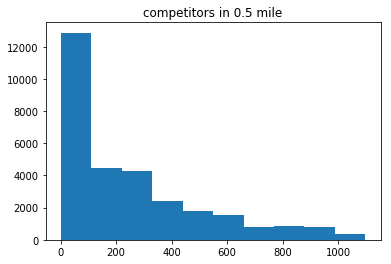

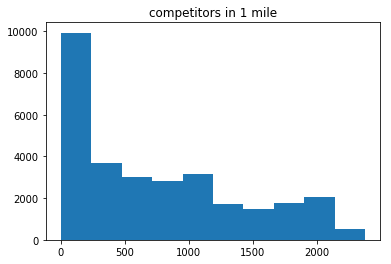

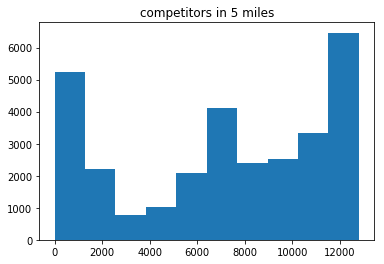

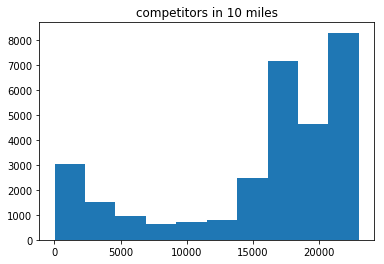

In [12]:
'''
#plot histograms of n competitors
mile_050 = [len(x) for x in locations_050m_new]
mile_1 = [len(x) for x in locations_1m_new]
mile_5 = [len(x) for x in locations_5m_new]
mile_10 = [len(x) for x in locations_10m_new]

plt.hist(mile_050)
plt.title('competitors in 0.5 mile')
plt.show()
plt.hist(mile_1)
plt.title('competitors in 1 mile')
plt.show()
plt.hist(mile_5)
plt.title('competitors in 5 miles')
plt.show()
plt.hist(mile_10)
plt.title('competitors in 10 miles')
plt.show()
'''

In [13]:
'''
#create a dataframe to save
listings['n_comp_050m'] = mile_050
listings['n_comp_1m'] = mile_1
listings['n_comp_5m'] = mile_5
listings['n_comp_10m'] = mile_10
listings['l_comp_050m'] = locations_050m_new
listings['l_comp_1m'] = locations_1m_new
listings['l_comp_5m'] = locations_5m_new
listings['l_comp_10m'] = locations_10m_new
comp = listings[['n_comp_050m', 'n_comp_1m', 'n_comp_5m', 'n_comp_10m', 'l_comp_050m', 'l_comp_1m', 'l_comp_5m', 'l_comp_10m']]
comp_n = listings[['n_comp_050m', 'n_comp_1m', 'n_comp_5m', 'n_comp_10m']]
comp'''

n_comp_050m  n_comp_1m  n_comp_5m  n_comp_10m  \
id                                                        
6627359            26        104      10081       19166   
13960394           32         90      10376       19956   
17992978           21        164       8083       18905   
11344969           34        124       9000       19088   
8985400           106        326       9061       21477   
6688906            91        493       9199       22166   
1751569            89        471       9217       22101   
4076913            73        313       8115       20690   
16573537           54        254       6528       19914   
674784             92        324       8517       20930   
1109548            89        354       8450       21249   
9563333            88        279       7884       20510   
16444577           68        262       6898       20110   
15005451           99        345       8192       21052   
9821709            97        344       8183       21045   
16577739           88        288       7990       20541   
13117571          115        362       9103       21661   
16577628           80        259       7525       20342   
795769            114        331       8845       21219   
14932311           73        278       7171       20227   
848816             95        370       8541       21392   
16711346           58        257       6692       20002   
2550816           102        403       8828       21632   
2856372            89        481       9203       22146   
15522950           96        343       8293       20909   
5697772            89        422       9113       21840   
14221019           79        250       7560       20335   
1171311            75        312       8125       20684   
17031009           75        329       7733       20524   
2483443            51        255       6290       19776   
...               ...        ...        ...         ...   
16258076           27        115      10423       19422   
14947276           21        145      10547       21669   
4067400            34        108       8815       19592   
11210689           21        130       7594       18001   
14290875           24        145       8365       19835   
11210446           19        123       7661       18165   
16911879           22         89       8649       18342   
16911209           28         88      10291       20062   
17040844           36        135       8452       19339   
4445915            29         86      10950       20165   
8192831            27        156      11224       21517   
2228537            28        141       9714       20795   
9647006            22         69      10855       20477   
5781348            29         90       9887       19046   
8309223            25         86      10942       21250   
15971127           19        158      10143       21309   
5395473            28        148       9834       19046   
11552737           20         64       8447       18160   
13118073           20         80      10481       20440   
4119371            28        111       9837       19136   
13451676           30        113      10294       19310   
4816682            29         85      10818       20162   
14749713           36        107       8803       19411   
7279397            34        131       8561       19456   
17960662           31        112      10866       21533   
6031273            30        113       9611       19238   
8327016            24         73       8740       18335   
15738299           28        116       8703       19688   
12525864           27        119      10541       19593   
12066922           28        114      10175       19246   

                                                l_comp_050m  \
id                                                            
6627359   [1759060, 6627359, 10392524, 17419253, 1588426...   
13960394  [12537595, 17793359, 4029464, 9647006, 1311807...   
17992978  [14749713, 15714418, 11344969,

In [14]:
'''
#file too big to pickle 
#with open('comp.pickle', 'wb') as handle:
#    pickle.dump(comp, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('comp_n.pickle', 'wb') as handle:
    pickle.dump(comp_n, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''
    

In [12]:
#bring in number of competitors

with open('comp_n.pickle', 'rb') as handle:
    competitors_n = pickle.load(handle)

listings = listings.merge(competitors_n, how='inner', left_index = True, right_index = True)


In [13]:
#Log Transform costs and other skewed distributions
cols = ['price',
        'weekly_price', 
        'monthly_price', 
        'security_deposit', 
        'cleaning_fee',
        'extra_people',
        'number_of_reviews',
        'monthly_occupancy',
        'monthly_income_est',
        'recent_monthly_occupancy',
        'recent_monthly_income_est',
        'review_scores_rating',
        'n_comp_050m', 
        'n_comp_1m', 
        'n_comp_5m', 
        'n_comp_10m']
ln_cols = [s + '_ln' for s in cols]
listings[ln_cols] = np.log(listings[cols]+ 1)

# Data Exploration

1. How many listings per year?
2. How many listings discontinue?
3. Where are listings located?
4. What factors are associated with drop out?
<br>
 -neighbourhood
<br>
 -rental type
<br>
 host status or location type
<br>
 listing factors (income, competition, reviews, etc) 

## How many listings per year?
## How many listings discontinue per year?

AirBnb saw tremendous growth from 2015-2017 almost doubling the number of listings from 15,000 to 30,000.  However, this growth masks the consistently high turnover seen during this time period.   For example, nearly one third of listings from 2017 dropped out a year later. This is high turonver rate warrants a closer look.  We will investigate the factors associated with drop out by examining 2017 listings in the rest of this notebook.

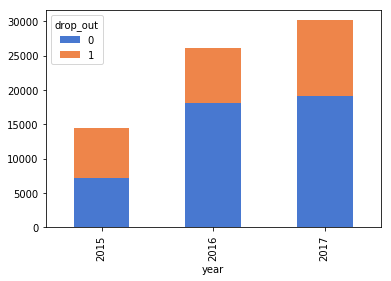

In [14]:
#How many listings per year?
#How many lisings discontinue per year?
sum_17 = listings_2017.drop_out.value_counts(dropna = False)
sum_16 = listings_2016.drop_out.value_counts(dropna = False)
sum_15 = listings_2015.drop_out.value_counts(dropna = False)

sum_17 = sum_17.to_frame()
sum_17['year'] = 2017
sum_16 = sum_16.to_frame()
sum_16['year'] = 2016
sum_15 = sum_15.to_frame()
sum_15['year'] = 2015

sums = pd.concat([sum_15, sum_16, sum_17])
sums = sums.reset_index()
sums.columns = ['drop_out', 'listings', 'year']

pal_dropout = ['#4878d0','#ee854a']
sums.pivot('year', 'drop_out')['listings'].plot(kind='bar', stacked=True, color = pal_dropout)

# Where are listings located?

Listings are not uniformly distributed throughout Los Angeles.  Instead they are concentrated along the center of the county with the most popular neighbourhoods being Venice (2045 listings), Hollywood (1981), Long Beach (1043), and Santa Monica (911).  These neighbourhoods are popular tourist areas, suggesting that a lot of AirBnb rentals in Los Angeles cater to tourists.  

In [16]:
#Set libraries
from bokeh.io import output_file, show, output_notebook
from bokeh.models import GeoJSONDataSource, ColumnDataSource, GMapOptions
from bokeh.plotting import figure, show, output_file, gmap
from bokeh.sampledata.sample_geojson import geojson
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models import HoverTool, LinearColorMapper, LogColorMapper, ColorBar, LogTicker
from bokeh.palettes import brewer
from bokeh.tile_providers import CARTODBPOSITRON

# Store the API key as a string from a config file
import configparser

config = configparser.ConfigParser()
config.read('API_KEYS.ini')
config.sections()

API_KEY = config['google.com']['API_KEY']

#Map the listings
#Set up google maps
gkey = API_KEY
map_options = GMapOptions(lat=34.0522, lng=-118.2437, map_type="roadmap", zoom=10)
p = gmap(gkey, map_options, tools=['wheel_zoom', 'pan', 'reset'], plot_width=1000, plot_height=900)


# Get the number of colors we'll need for the plot.
colors = pal_dropout

# Create a color map for drop_out values: blue for 0, orange for 1
colormap = {i: colors[i] for i in listings.drop_out.unique()} 

# Create a list of colors for each value that we will be looking at.
colors = [colormap[x] for x in listings.drop_out]


#Add listing points as a Column Data Source
listings['drop_out_color'] = colors
listings_col = ColumnDataSource(listings[['latitude', 'longitude', 'drop_out', 'drop_out_color']])
listings_mp = p.circle('longitude', 'latitude', source = listings_col, color= '#4878d0', size=1)



listings_mp_hover = HoverTool(renderers=[listings_mp])
listings_mp_hover.tooltips=[("id", "@id"),
                            ("drop_out", '@drop_out'),]
p.add_tools(listings_mp_hover)
p.add_tile(CARTODBPOSITRON)


output_notebook()

show(p)


Loading BokehJS ...

In [17]:
neighbourhoods_shapes = gpd.read_file('InsideAirBnb/neighbourhoods_17.geojson')
neighbourhoods_shapes['neighbourhood'] = neighbourhoods_shapes['neighbourhood'].str.lower()

neighbourhoods = listings.groupby('neighbourhood_cleansed')['drop_out'].agg({'listings': np.size, 'dropout_p': np.mean})
neighbourhoods = neighbourhoods[neighbourhoods['listings'] > 50]
neighbourhoods.reset_index(inplace = True)

neighbourhoods = pd.merge(neighbourhoods, neighbourhoods_shapes, left_on = 'neighbourhood_cleansed', right_on = 'neighbourhood', how = 'left')
neighbourhoods = neighbourhoods.drop(['neighbourhood', 'neighbourhood_group'], axis=1)
gdf = gpd.GeoDataFrame(neighbourhoods, geometry='geometry')
geo_source = GeoJSONDataSource(geojson = gdf.to_json())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [18]:
colormap_neighbourhood = LinearColorMapper(palette=cc.blues, low=0, high=neighbourhoods.listings.max())

p = gmap(gkey, map_options, tools=['wheel_zoom', 'pan', 'reset'], plot_width=1000, plot_height=900)

neighbourhood_mp = p.patches('xs', 'ys', fill_alpha=0.9, fill_color={'field': 'listings', 'transform': colormap_neighbourhood},
          line_color='black', line_width=0.5, source=geo_source)

nbhover = HoverTool(renderers=[neighbourhood_mp])
nbhover.tooltips=[("Neighbourhood", "@neighbourhood_cleansed"),
       ("Percent Drop Out", "@dropout_p{(.0000)}"),
       ("Listings", "@listings"),
       ]
p.add_tools(nbhover)
p.add_tile(CARTODBPOSITRON)

color_bar = ColorBar(color_mapper=colormap_neighbourhood, label_standoff=12, border_line_color=None, location=(0,0), orientation = 'horizontal')

p.title.text = "Listings per neighbourhood with more than 50 listings"
p.title.align = "center"

p.add_layout(color_bar, 'above')

show(p)

## What neighborhoods are associated with drop out?
Neighborhood drop out rates in 2017 ranged from 14% in Jefferson Park to 59% in Diamond Bar.  Over 50% of listings drop out the following year in 10 of the 106 neighbourhoods with more than 50 listings.   

In [19]:
colormap_neighbourhood = LinearColorMapper(palette=cc.blues, low=neighbourhoods.dropout_p.min(), high=neighbourhoods.dropout_p.max())

p = gmap(gkey, map_options, tools=['wheel_zoom', 'pan', 'reset'], plot_width=1000, plot_height=900)

neighbourhood_mp = p.patches('xs', 'ys', fill_alpha=0.9, fill_color={'field': 'dropout_p', 'transform': colormap_neighbourhood},
          line_color='black', line_width=0.5, source=geo_source)

nbhover = HoverTool(renderers=[neighbourhood_mp])
nbhover.tooltips=[("Neighbourhood", "@neighbourhood_cleansed"),
       ("Percent Drop Out", "@dropout_p{(0.000)}"),
       ("Listings", "@listings"),
       ]
p.add_tools(nbhover)
p.add_tile(CARTODBPOSITRON)

color_bar = ColorBar(color_mapper=colormap_neighbourhood, label_standoff=12, border_line_color=None, location=(0,0), orientation = 'horizontal')
p.add_layout(color_bar, 'above')

p.title.text = "Drop out rate among neighbourhoods with more than 50 listings"
p.title.align = "center"

show(p)

In [20]:
#Neighborhood
pd.set_option('display.max_rows', 260)
x = listings.groupby('neighbourhood_cleansed')['drop_out'].agg({'N': np.size, 'dropout_p': np.mean})
x[x['N'] > 50].sort_values('dropout_p', ascending = False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


N  dropout_p
neighbourhood_cleansed                                
diamond bar                              78   0.589744
walnut                                   75   0.573333
chinatown                                65   0.569231
playa vista                              87   0.563218
west covina                              66   0.560606
marina del rey                          163   0.539877
arcadia                                 169   0.538462
boyle heights                            88   0.534091
canoga park                              61   0.524590
rancho palos verdes                      56   0.517857
beverly crest                           145   0.517241
exposition park                         140   0.492857
hawthorne                                67   0.477612
downtown                                896   0.469866
larchmont                               122   0.450820
brentwood                               208   0.442308
rowland heights                         335   0.441791
pico-robertson                          204   0.441176
baldwin hills/crenshaw                   64   0.437500
hollywood                              1918   0.431700
northridge                               72   0.430556
palms                                   311   0.427653
sun valley                               61   0.426230
koreatown                               616   0.425325
santa clarita                            87   0.425287
van nuys                                204   0.421569
west hollywood                          834   0.417266
santa monica                            911   0.414929
mid-wilshire                            714   0.411765
lincoln heights                          56   0.410714
monterey park                           118   0.406780
north hollywood                         433   0.406467
westwood                                460   0.404348
vermont square                           58   0.396552
encino                                  139   0.395683
hacienda heights                         79   0.392405
long beach                             1043   0.390221
inglewood                               166   0.385542
tarzana                                 109   0.385321
sawtelle                                508   0.383858
arlington heights                       115   0.382609
studio city                             366   0.382514
el segundo                               92   0.380435
sherman oaks                            424   0.379717
fairfax                                 384   0.377604
west hills                               67   0.373134
westlake                                464   0.372845
mar vista                               400   0.372500
hollywood hills west                    452   0.369469
harvard heights                          76   0.368421
malibu                                  316   0.367089
south pasadena                           63   0.365079
san gabriel                              96   0.364583
east hollywood                          419   0.362768
playa del rey                           118   0.355932
westchester                             184   0.353261
hermosa beach                           139   0.352518
glassell park                            88   0.352273
hollywood hills                         767   0.349413
temple city                              83   0.349398
west los angeles                        118   0.347458
gardena                                  72   0.347222
beverly hills                           380   0.344737
pomona                                   96   0.343750
beverly grove                           515   0.343689
woodland hills                          262   0.343511
pacific palisades                       186   0.338710
burbank                                 249   0.337349
mid-city                                400   0.335000
west adams                               63   0.333333
view park-windsor hills                  64   0.328125
el sereno                  

## What rental type factors are associated with drop out?

Condominiums, lofts, townhouses, and apartments have the highest drop out rates.  However, the room_type may be the most important rental type factor.  Shared room listings have also 60% probability of dropping out whereas private rooms or entire home listings have less than 40% probability of dropping out

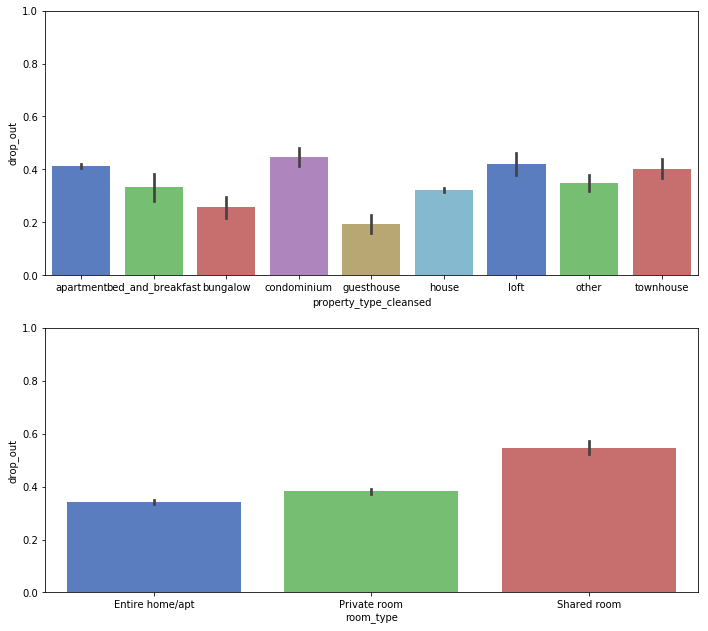

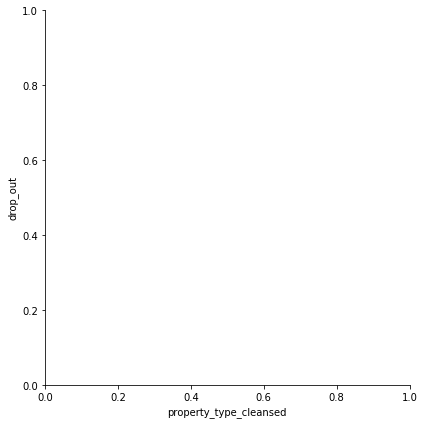

<Figure size 432x432 with 0 Axes>

In [21]:
#Property_type
#listings.groupby('property_type_cleansed')['drop_out'].agg({'N': np.size, 'dropout_p': np.mean}).sort_values('dropout_p', ascending = False)
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(11.7, 10.7))

sns.factorplot(ax = axs[0], x="property_type_cleansed", y="drop_out", data = listings,
                   size=6, kind="bar", palette="muted")
sns.factorplot(ax = axs[1], x="room_type", y="drop_out", data = listings,
                   size=6, kind="bar", palette="muted")
axs[0].set(ylim=(0, 1))
axs[1].set(ylim=(0, 1))

plt.gcf().clear()

## What host factors are associated with drop out?

Listing hosts that are super hosts or live in the same neighborhood as the listing tend to have lower drop out rates.  Also hosts of listings that are retained the next year have been hosting longer than hosts of listings drop out.  

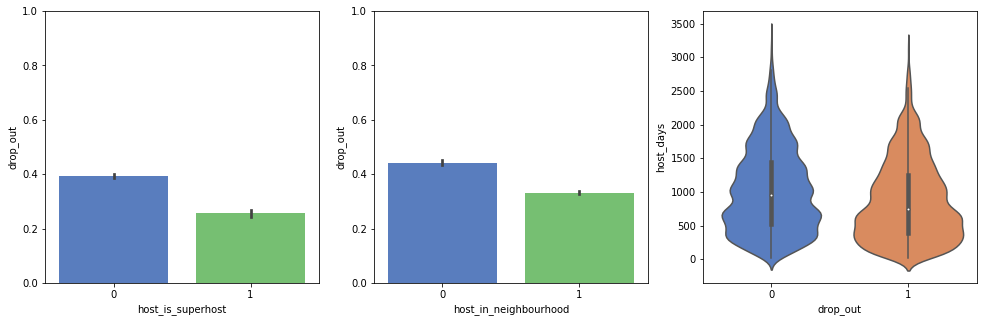

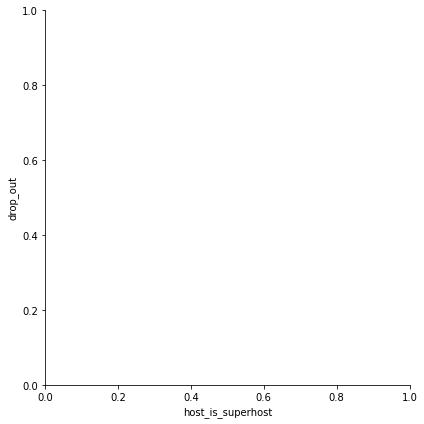

<Figure size 432x432 with 0 Axes>

In [22]:
#superhost status
fig, axs = plt.subplots(nrows = 1, ncols = 3,figsize=(16.7, 5))
axs[0].set(ylim=(0, 1))
axs[1].set(ylim=(0, 1))
sns.factorplot(x="host_is_superhost", y="drop_out", data = listings,
                   size=6, kind="bar", palette="muted", ax = axs[0])
sns.factorplot(x="host_in_neighbourhood", y="drop_out", data = listings,
                   size=6, kind="bar", palette="muted", ax = axs[1])
sns.violinplot(x = "drop_out", y = "host_days", data=listings, palette=pal_dropout, ax = axs[2])

plt.gcf().clear()

## What other factors are associated with drop out?

When looking at metrics related to listing popularity, there is little difference between listings that drop out and listings that are retained the next year.  Both listing types have a similar number of competitors within a half mile and within a mile radii. Both listings also have prices, recent monthly occupancy, and recent estimated monthly income.  There are some differences: listings that do not drop out have more reviews, a slightly higher rating, and less availability for the next 60 days, but its unclear whether this difference is meaningful. 

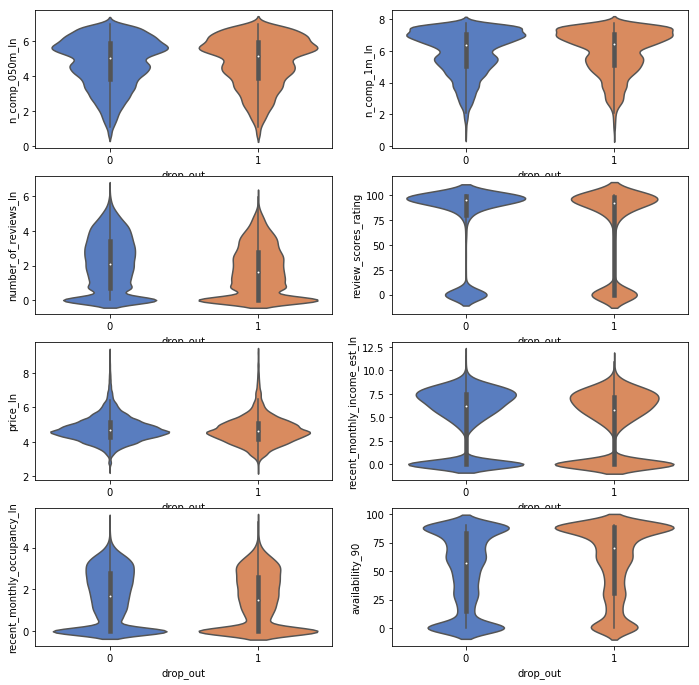

In [24]:
#Violin Plots

fig, axs = plt.subplots(nrows = 4, ncols = 2,figsize=(11.7, 11.7))

sns.violinplot(x="drop_out", y="n_comp_050m_ln", palette=pal_dropout, data=listings, ax=axs[0,0])
sns.violinplot(x="drop_out", y="n_comp_1m_ln", palette=pal_dropout, data=listings, ax=axs[0,1])
sns.violinplot(x="drop_out", y="number_of_reviews_ln", data=listings, palette=pal_dropout, ax = axs[1,0])
sns.violinplot(x="drop_out", y="review_scores_rating", data=listings, palette=pal_dropout, ax=axs[1,1])
sns.violinplot(x="drop_out", y="price_ln", data=listings, palette=pal_dropout, ax = axs[2,0])
sns.violinplot(x="drop_out", y="recent_monthly_income_est_ln", data=listings, palette=pal_dropout, ax = axs[2,1])
sns.violinplot(x="drop_out", y="recent_monthly_occupancy_ln", data=listings, palette=pal_dropout, ax = axs[3,0])
sns.violinplot(x="drop_out", y="availability_90", data=listings, palette=pal_dropout, ax = axs[3,1])

# Assessment

Overall, neighbourhood, property type and host factors seem to have the strongest association with drop out status.  Listing popularity and monthly income do not seem to strongly predict drop out status.  

# Scratch Code

In [306]:
#Host verifications
x = [col for col in listings if col.startswith('host_v')]
for name in x:
    y = listings.groupby(name)['drop_out'].agg({'N': np.size, 'dropout_p': np.mean})
    print(y)


                    N  dropout_p
host_v_reviews                  
0                3385   0.384343
1               26767   0.365413
                  N  dropout_p
host_v_email                  
0              1303   0.466616
1             28849   0.363063
                   N  dropout_p
host_v_selfie                  
0              29852   0.366709
1                300   0.450000
                       N  dropout_p
host_v_work_email                  
0                  26926   0.367600
1                   3226   0.367018
                 N  dropout_p
host_v_amex                  
0            29756   0.367892
1              396   0.340909
                          N  dropout_p
host_v_manual_online                  
0                     29925   0.368053
1                       227   0.299559
                  N  dropout_p
host_v_jumio                  
0             18116   0.345054
1             12036   0.401379
                  N  dropout_p
host_v_weibo                  
0         

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [305]:
#Host verifications
x = [col for col in listings if col.startswith('amenities_')]
for name in x:
    y = listings.groupby(name)['drop_out'].agg({'N': np.size, 'dropout_p': np.mean})
    print(y)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


                            N  dropout_p
amenities_Pets_allowed                  
0                       24833   0.366045
1                        5319   0.374506
                                   N  dropout_p
amenities_Suitable_for_events                  
0                              27838   0.364466
1                               2314   0.404494
                                N  dropout_p
amenities_Private_entrance                  
0                           27847   0.370812
1                            2305   0.327983
                                N  dropout_p
amenities_Indoor_fireplace                  
0                           23277   0.368561
1                            6875   0.364073
                    N  dropout_p
amenities_Cats                  
0               28518   0.373168
1                1634   0.269278
                                   N  dropout_p
amenities_Family/kid_friendly                  
0                              13254   0.366833
1       

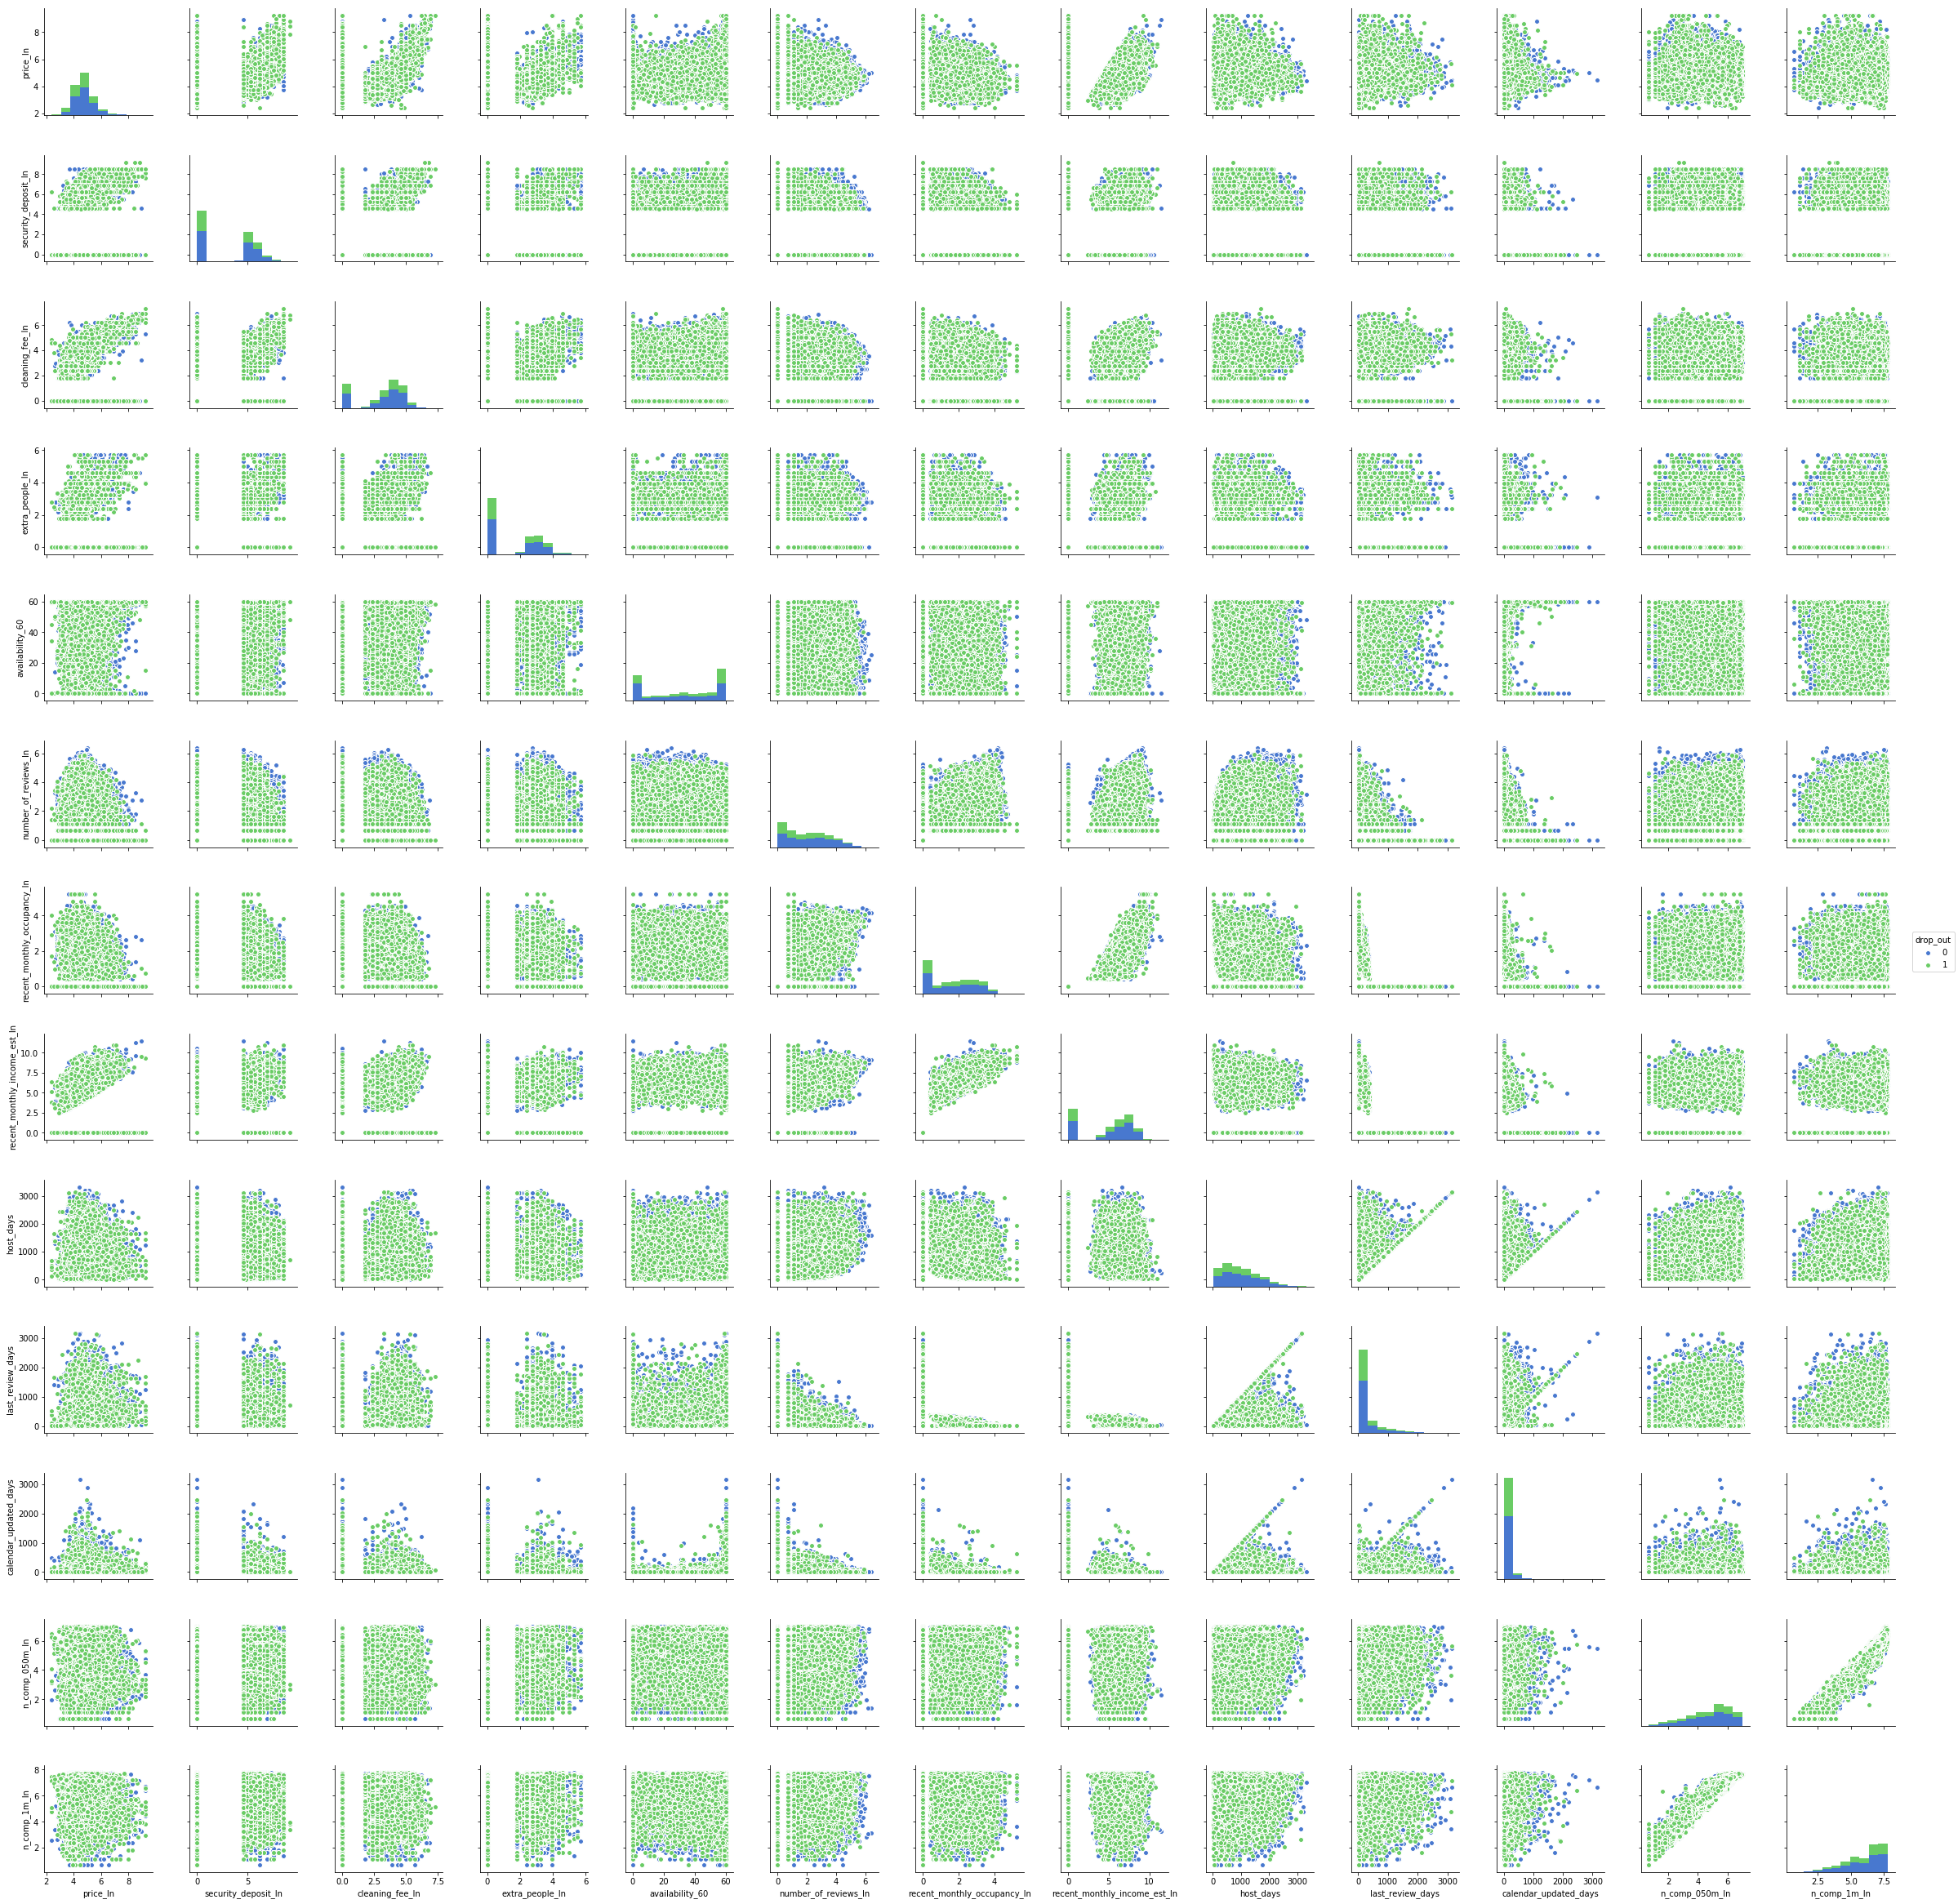

In [21]:


cont_vars = [
    'price_ln',
    'security_deposit_ln',
    'cleaning_fee_ln',
    'extra_people_ln',
    'availability_60',
    'number_of_reviews_ln',
    'recent_monthly_occupancy_ln', 
    'recent_monthly_income_est_ln',
    'host_days',
    'last_review_days',
    'calendar_updated_days',
    'n_comp_050m_ln',
    'n_comp_1m_ln'
    ]

sns.set_palette("muted")

x = sns.pairplot(listings, vars = cont_vars, hue="drop_out")
x.savefig("output.png")
x

In [14]:
#Create a dataset of new 2018 listings for comparison
listings_2018_new = listings_2018[listings_2018['new'] == 1].copy()

#Do some light cleaning
listings_2018_new.set_index('id', inplace = True)


#All dates to datetime
cols = ['last_scraped',
        'host_since', 
        'first_review', 
        'last_review']
time_format = '%Y-%m-%d'
listings_2018_new[cols]= (listings_2018_new[cols].apply(pd.to_datetime, format=time_format))
reviews_2018['date'] = pd.to_datetime(reviews_2018['date'])

#All dollars to float
cols = ['price',
        'weekly_price', 
        'monthly_price', 
        'security_deposit', 
        'cleaning_fee',
        'extra_people'
       ]
listings_2018_new[cols] = (listings_2018_new[cols]
                  .replace({'\$': '', ',': ''}, regex=True)
                  .astype(float))

#Transform review_scores_rating
listings_2018_new.loc[listings_2018_new['review_scores_rating'].isnull(), 'review_scores_rating'] = 0
listings_2018_new['review_scores_rating_ln'] = np.log(listings_2018_new['review_scores_rating']+ 1)


#get number reviews from the year from reviews dataframe before scrape date
scrape_date = max(listings_2018_new['last_scraped'])
yr_ago =  scrape_date - timedelta(days=365)
yr_ago
reviews_2018 = reviews_2018[(reviews_2018['date']>= yr_ago)]
reviews_sum = reviews_2018.groupby('listing_id')['date'].agg({'recent_reviews': np.size, 'min': np.min})
reviews_sum['days'] = (scrape_date - reviews_sum['min']).dt.days
reviews_sum['recent_reviews_per_month'] = (np.divide(reviews_sum['recent_reviews'], reviews_sum['days']))*30.4
reviews_sum

#merge data back into listings dataframe and zero fill
listings_2018_new = pd.merge(listings_2018_new, reviews_sum[['recent_reviews', 'recent_reviews_per_month']], left_index = True, right_index = True, how = 'left')
listings_2018_new.loc[listings_2018_new['recent_reviews'].isnull(), 'recent_reviews'] = 0
listings_2018_new.loc[listings_2018_new['recent_reviews_per_month'].isnull(), 'recent_reviews_per_month'] = 0

#Get recent monthly income_est
listings_2018_new['recent_monthly_occupancy'] = 3 * (listings_2018_new['recent_reviews_per_month']/0.50) 
listings_2018_new['recent_monthly_income_est'] = listings_2018_new['recent_monthly_occupancy']* listings_2018_new['price']
listings_2018_new['recent_monthly_income_est_ln'] = np.log(listings_2018_new['recent_monthly_income_est']+ 1)


x = listings_2018_new[['review_scores_rating', 'review_scores_rating_ln', 'recent_monthly_income_est', 'recent_monthly_income_est_ln','last_scraped']]
y = listings.loc[listings.drop_out ==1, ['review_scores_rating','review_scores_rating_ln','recent_monthly_income_est','recent_monthly_income_est_ln', 'last_scraped']]


compare_old_new = pd.concat([x, y])
compare_old_new['year'] = compare_old_new['last_scraped'].dt.year
compare_old_new['category'] =compare_old_new['year'].apply(lambda x: 'drop_out' if x == 2017 else 'new' )

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


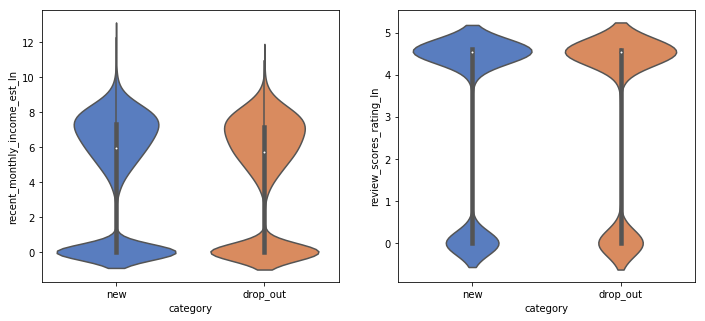

In [81]:
fig, axs = plt.subplots(nrows = 1, ncols = 2,figsize=(11.7, 5))

sns.violinplot(x = "category", y = "recent_monthly_income_est_ln", data=compare_old_new, palette=pal_dropout, ax = axs[0])
sns.violinplot(x = "category", y = "review_scores_rating_ln", data=compare_old_new, palette=pal_dropout, ax = axs[1])